In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# for Kaggle
# import sys
# sys.path.insert(0, '/kaggle/input/gan-training')

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def imshow(img, ax=None, cmap='viridis', affine: bool = True):
    npimg = img.detach().numpy()
    if affine:  # если изначально к изображениям применялось это преобразование
        npimg = npimg / 2 + 0.5  # обратное афинное преобразование
    if ax is None:
        if npimg.shape[0] == 1:  # 1 channel
            plt.imshow(np.squeeze(npimg), cmap=cmap)
        else:  # 3 channels
            plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap)
        plt.show()
    else:
        if npimg.shape[0] == 1:  # 1 channel
            ax.imshow(np.squeeze(npimg), cmap=cmap)
        else:  # 3 channels
            ax.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap)

In [9]:
import torch
from device import get_local_device
from gan import GAN


def gen_several_images(gan_model: GAN, n: int = 5, y=None, figsize=(13, 13), imshow_fn=imshow):
    """
    Выводит n изображений, сгенерированных gan_model, в строке
    """
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=figsize)
    gan_model.to(get_local_device())
    if isinstance(y, torch.Tensor):
        y = y.to(get_local_device())
    with torch.no_grad():
        noise_batch = gan_model.gen_noise(n).to(get_local_device())
        gen_batch = gan_model.generator(noise_batch, y)
        
    if n == 1:
        axs = [axs]
    for i, (tensor, ax) in enumerate(zip(gen_batch, axs)):
        imshow_fn(tensor.cpu(), ax=ax)
        if y is not None and isinstance(y, torch.Tensor):
            ax.set_xlabel(y[i].item())
        
    plt.show()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



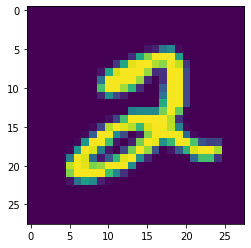

In [5]:
from data import get_mnist_dataset, default_image_transform

mnist_dataset = get_mnist_dataset()
imshow(mnist_dataset[5][0])

# Генерация MNIST

In [5]:
import contextlib
import os
from enum import Enum, auto
from typing import Tuple, Generator, Optional, List

import torch

import data
from discriminators import MNISTDiscriminator
from gan import GAN
from generators import MNISTGenerator
from main import init_logger, Environment
from metrics import Metric, CriticValuesDistributionMetric
from normalization import apply_normalization, SpectralNormalizer
from results_storage import ResultsStorage
from storage import ExperimentsStorage
from train import Stepper, WganEpochTrainer, GanTrainer
from wandb_logger import WandbCM


def init_storage() -> ExperimentsStorage:
    # === config variables ===
    experiments_dir = './experiments'
    checkpoint_filename = './training_checkpoint'
    model_state_filename = './model_state'
    # ========================
    return ExperimentsStorage(experiments_dir=experiments_dir, checkpoint_filename=checkpoint_filename,
                              model_state_filename=model_state_filename)


experiments_storage = init_storage()

def init_results_storage() -> ResultsStorage:
    # === config variables ===
    results_dir = './results'
    results_filename = './results.json'
    # ========================
    return ResultsStorage(storage_dir=results_dir, results_filename=results_filename)


results_storage = init_results_storage()


ENV = Environment.KAGGLE


def form_metric() -> Metric:
    return CriticValuesDistributionMetric(values_cnt=1000)


def form_gan_trainer(model_name: str, gan_model: Optional[GAN] = None, n_epochs: int = 100) -> Generator[Tuple[int, GAN], None, GAN]:
    """
    :return: a generator that yields (epoch number, gan_model after this epoch)
    """
    # для логирования используется WandB
    logger_cm_fn = init_logger(model_name, project_name='mid_demo')
    metric = form_metric()
    result_metrics = None
    
    train_dataset = data.get_mnist_dataset(train=True, keep_labels=False)
    val_dataset = data.get_mnist_dataset(train=False, keep_labels=False)
    train_dataset = data.UnifiedDatasetWrapper(train_dataset)
    val_dataset = data.UnifiedDatasetWrapper(val_dataset)
    
    noise_dimension = 50

    def uniform_noise_generator(n: int) -> torch.Tensor:
        return 2*torch.rand(size=(n, noise_dimension)) - 1  # [-1, 1]

    generator = MNISTGenerator(noise_dim=noise_dimension)
    discriminator = MNISTDiscriminator()
    discriminator = apply_normalization(discriminator, SpectralNormalizer)

    if gan_model is None:
        gan_model = GAN(generator, discriminator, uniform_noise_generator)

    generator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(generator.parameters(), lr=1e-3)
    )

    discriminator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(discriminator.parameters(), lr=1e-5)
    )

    epoch_trainer = WganEpochTrainer(n_critic=5, batch_size=100)

    model_dir = experiments_storage.get_model_dir(model_name)
    experiment_info = results_storage.get_experiment_info(model_name)
    trainer = GanTrainer(model_dir=model_dir, use_saved_checkpoint=True, save_checkpoint_once_in_epoch=10)
    train_gan_generator = trainer.train(gan_model=gan_model,
                                        train_dataset=train_dataset, val_dataset=val_dataset,
                                        generator_stepper=generator_stepper,
                                        critic_stepper=discriminator_stepper,
                                        epoch_trainer=epoch_trainer,
                                        n_epochs=n_epochs,
                                        metric=metric,
                                        logger_cm_fn=logger_cm_fn,
                                        result_metrics=result_metrics,
                                        results_info=experiment_info)
    return train_gan_generator

In [10]:
gan_trainer = form_gan_trainer(model_name='mnist demo, 1e-3, 1e-5', n_epochs=10)

100%|██████████| 600/600 [01:57<00:00,  5.10it/s]


epochs done: 1


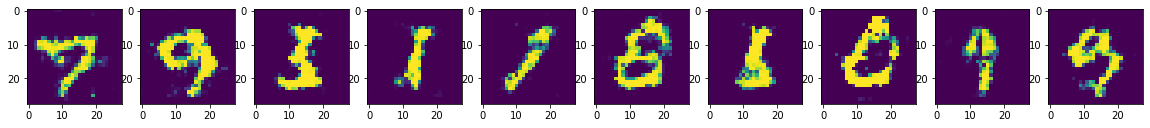

100%|██████████| 600/600 [01:45<00:00,  5.67it/s]


epochs done: 2


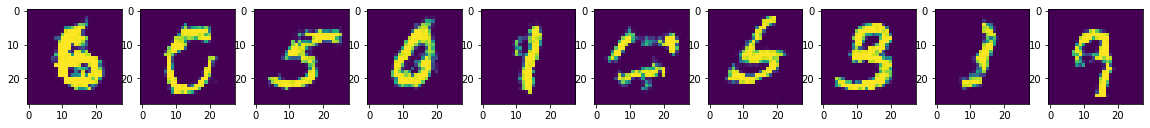

100%|██████████| 600/600 [01:45<00:00,  5.67it/s]


epochs done: 3


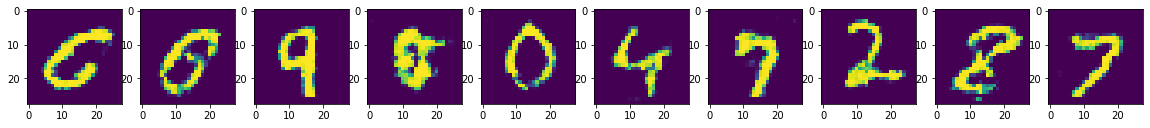

100%|██████████| 600/600 [01:46<00:00,  5.66it/s]


epochs done: 4


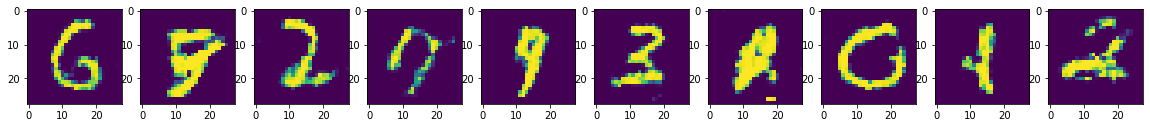

100%|██████████| 600/600 [01:46<00:00,  5.65it/s]


epochs done: 5


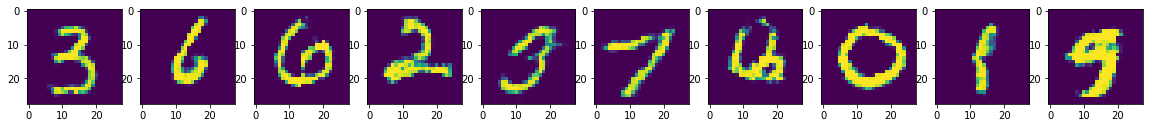

100%|██████████| 600/600 [01:45<00:00,  5.67it/s]


epochs done: 6


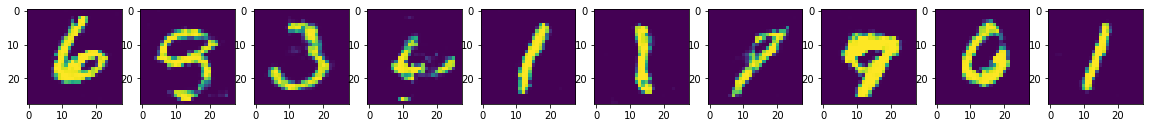

100%|██████████| 600/600 [01:46<00:00,  5.64it/s]


epochs done: 7


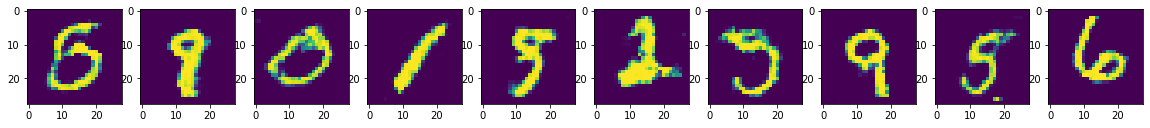

100%|██████████| 600/600 [01:45<00:00,  5.68it/s]


epochs done: 9


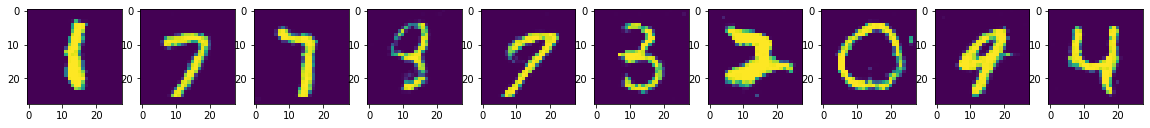

100%|██████████| 600/600 [01:45<00:00,  5.69it/s]


epochs done: 10


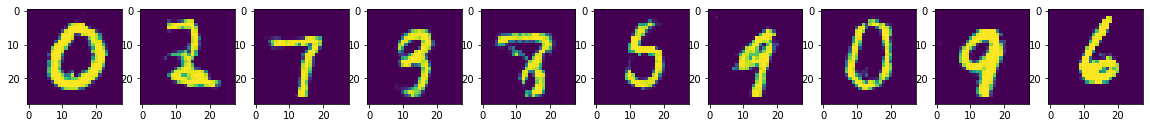

epoch,▁▂▃▃▄▅▆▆▇█
train/generator/loss,█▁▂▂▄▃▅▅▅▆
epoch,10
train/generator/loss,2.36725


In [11]:
for epoch, gan in gan_trainer:
    print(f'epochs done: {epoch-1}')
    gen_several_images(gan, 10, figsize=(20, 11))

Страница с логами в WandB - [тык](https://wandb.ai/trickman/mid_demo/runs/11d391c6?workspace=user-trickman). Можно видеть, что ошибка генератора увеличивается, но несмотря на это качество генерации визуально улучшается. Рост ошибки можно обосновать тем, что дискриминатор "обгоняет" генератор в обучении.

# Условная генерация MNIST

Единственное отличие в коде - использование других моделей (с ними лучше получается условная генерация), указание кол-ва классов для них и использование датасета с метками классов.

In [10]:
from discriminators import MlpMnistDiscriminator
from generators import MlpMnistGenerator


def form_gan_trainer(model_name: str, gan_model: Optional[GAN] = None, n_epochs: int = 100) -> Generator[Tuple[int, GAN], None, GAN]:
    """
    :return: a generator that yields (epoch number, gan_model after this epoch)
    """
    # для логирования используется WandB
    logger_cm_fn = init_logger(model_name, project_name='mid_demo')
    metric = form_metric()
    result_metrics = None
    
    train_dataset = data.get_mnist_dataset(train=True, keep_labels=True)
    val_dataset = data.get_mnist_dataset(train=False, keep_labels=True)
    train_dataset = data.UnifiedDatasetWrapper(train_dataset)
    val_dataset = data.UnifiedDatasetWrapper(val_dataset)
    
    noise_dimension = 50

    def uniform_noise_generator(n: int) -> torch.Tensor:
        return 2*torch.rand(size=(n, noise_dimension)) - 1  # [-1, 1]
    
    condition_classes_cnt = 10
    generator = MlpMnistGenerator(noise_dim=noise_dimension, condition_classes_cnt=condition_classes_cnt)
    discriminator = MlpMnistDiscriminator(condition_classes_cnt=condition_classes_cnt)
    discriminator = apply_normalization(discriminator, SpectralNormalizer)

    if gan_model is None:
        gan_model = GAN(generator, discriminator, uniform_noise_generator)

    generator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(generator.parameters(), lr=1e-3)
    )

    discriminator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(discriminator.parameters(), lr=1e-5)
    )

    epoch_trainer = WganEpochTrainer(n_critic=5, batch_size=100)

    model_dir = experiments_storage.get_model_dir(model_name)
    experiment_info = results_storage.get_experiment_info(model_name)
    trainer = GanTrainer(model_dir=model_dir, use_saved_checkpoint=True, save_checkpoint_once_in_epoch=10)
    train_gan_generator = trainer.train(gan_model=gan_model,
                                        train_dataset=train_dataset, val_dataset=val_dataset,
                                        generator_stepper=generator_stepper,
                                        critic_stepper=discriminator_stepper,
                                        epoch_trainer=epoch_trainer,
                                        n_epochs=n_epochs,
                                        metric=metric,
                                        logger_cm_fn=logger_cm_fn,
                                        result_metrics=result_metrics,
                                        results_info=experiment_info)
    return train_gan_generator

In [11]:
gan_trainer = form_gan_trainer(model_name='cond. mnist demo, 1e-3, 1e-5', n_epochs=10)

epoch,▁
train/generator/loss,▁
epoch,1
train/generator/loss,0.02955


100%|██████████| 600/600 [00:57<00:00, 10.51it/s]


epochs done: 1


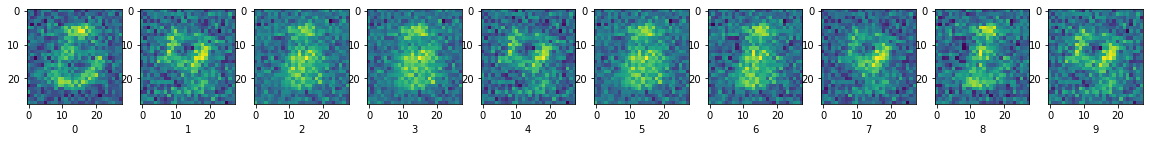

100%|██████████| 600/600 [00:40<00:00, 14.88it/s]


epochs done: 2


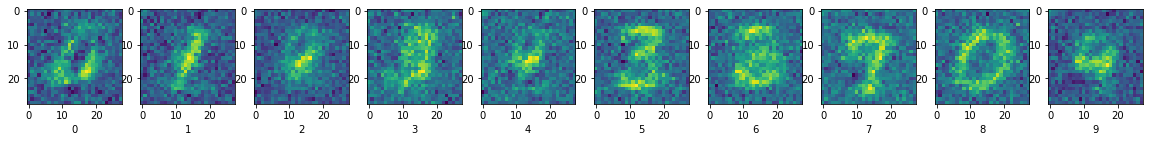

100%|██████████| 600/600 [00:40<00:00, 14.74it/s]


epochs done: 3


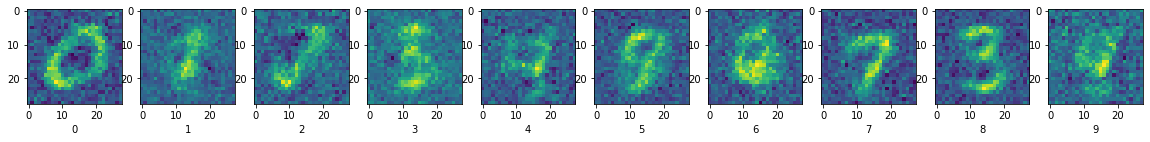

100%|██████████| 600/600 [00:40<00:00, 14.88it/s]


epochs done: 4


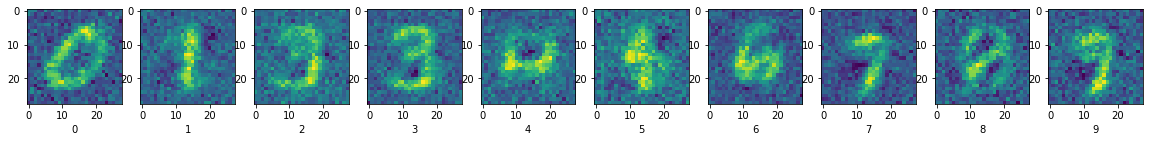

100%|██████████| 600/600 [00:40<00:00, 14.64it/s]


epochs done: 5


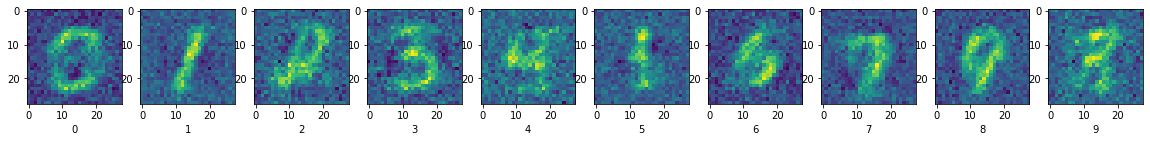

100%|██████████| 600/600 [00:40<00:00, 14.87it/s]


epochs done: 6


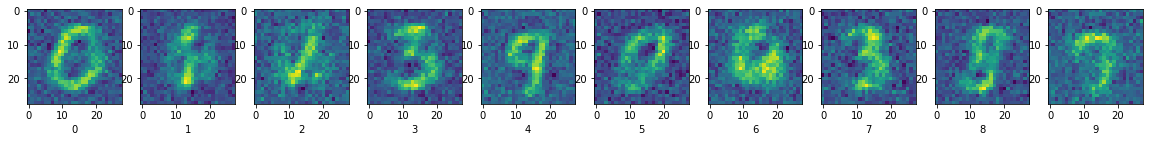

100%|██████████| 600/600 [00:40<00:00, 14.94it/s]


epochs done: 7


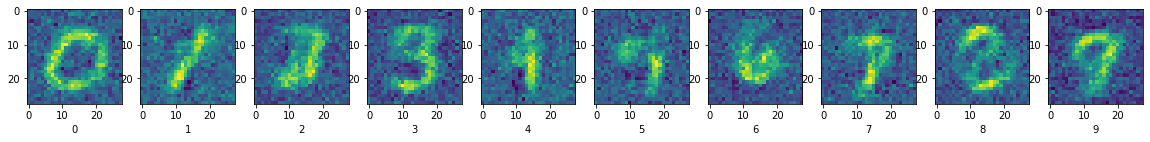

100%|██████████| 600/600 [00:40<00:00, 14.74it/s]


epochs done: 8


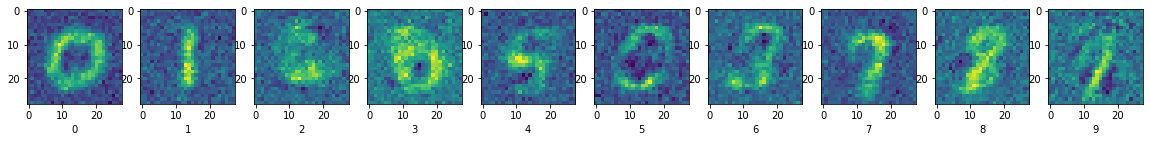

100%|██████████| 600/600 [00:39<00:00, 15.01it/s]


epochs done: 9


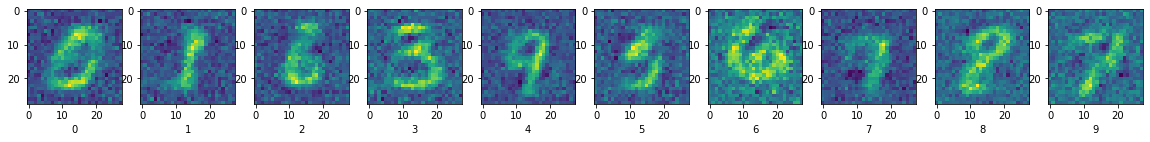

100%|██████████| 600/600 [00:40<00:00, 14.84it/s]


epochs done: 10


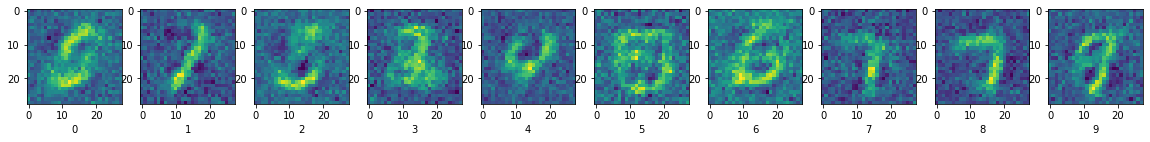

epoch,▁▂▃▃▄▅▆▆▇█
train/generator/loss,█▁▁▁▁▁▁▂▁▂
epoch,10
train/generator/loss,0.00847


In [12]:
all_labels = torch.arange(10)
for epoch, gan in gan_trainer:
    print(f'epochs done: {epoch-1}')
    gen_several_images(gan, 10, y=all_labels, figsize=(20, 11))

Страница с логами в WandB - [тык](https://wandb.ai/trickman/mid_demo/runs/1d2y5ai7?workspace=user-trickman).

Можно видеть не очень качественную, но всё же условную генерацию.

Моей целью было проверить корректность реализации обучения GAN-ов, поэтому я использовал готовые архитектуры моделей, на которых разумный результат точно должен достигаться.